In [1]:
%matplotlib inline

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# MNIST 데이터셋 불러오기

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
# MNIST 데이터셋을 다운로드 & dataloader 생성
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [8]:
# 이미지 여러 장 출력하는 함수
def show_images(images, labels):
    images = images / 2 + 0.5 # 이미지를 출력할 수 있게 -1 ~ 1 사이의 값으로 변환
    npimg = images.numpy() # 이미지를 numpy 배열로 변환
    fig, axes = plt.subplots(1, 8, figsize=(12, 12))

    # 이미지 출력
    for i in range(8):
        ax = axes[i]
        ax.imshow(npimg[i].reshape(28, 28), cmap='gray')
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')
    plt.show()

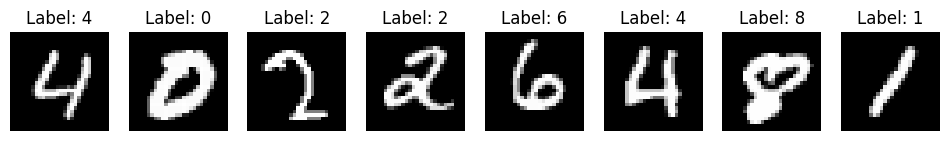

In [9]:
# 이미지 배치를 불러옴
dataiter = iter(dataloader)
images, labels = next(dataiter)

show_images(images, labels)

In [10]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [11]:
latent_dim = 100
img_shape = 28 * 28

generator = Generator(input_dim=latent_dim, output_dim=img_shape)
discriminator = Discriminator(input_dim=img_shape)

lr = 0.0002
b1 = 0.5
b2 = 0.999

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = nn.BCELoss()

In [14]:
import os
if not os.path.exists('images'):
    os.makedirs('images')


In [15]:
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator.to(device)
discriminator.to(device)
adversarial_loss.to(device)

for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        
        # 진짠지 가짠지에 대한 레이블 생성
        valid = torch.ones((imgs.size(0), 1), requires_grad=False).to(device)
        fake = torch.zeros((imgs.size(0), 1), requires_grad=False).to(device)
        
        # 진짜 이미지 (데이터셋에서 불러온거)
        real_imgs = imgs.view(imgs.size(0), -1).to(device)
        
        ### 생성기 학습
        optimizer_G.zero_grad()
        
        # 랜덤 노이즈로부터 이미지 생성
        z = torch.randn((imgs.size(0), latent_dim)).to(device)
        gen_imgs = generator(z)
        
        # 생성된 이미지를 판별자에 넣어서 결과 확인
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()
        

        ### 판별기 학습
        optimizer_D.zero_grad()

        # 진짜 이미지 판별
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()
        optimizer_D.step()
        
        if i % 400 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i}/{len(dataloader)} \
                  Loss D: {d_loss.item()}, loss G: {g_loss.item()}")
            
    # 중간 단계 확인을 위해 생성된 이미지 저장
    if epoch % 10 == 0:
        gen_imgs = gen_imgs.view(gen_imgs.size(0), 1, 28, 28)
        save_image(gen_imgs.data[:25], f"images/{epoch}.png", nrow=5, normalize=True)


Epoch [0/50] Batch 0/938                   Loss D: 0.1220121830701828, loss G: 1.879439115524292
Epoch [0/50] Batch 400/938                   Loss D: 1.8231042623519897, loss G: 11.60977840423584
Epoch [0/50] Batch 800/938                   Loss D: 0.08167549967765808, loss G: 3.125018835067749
Epoch [1/50] Batch 0/938                   Loss D: 0.047104086726903915, loss G: 3.223438262939453
Epoch [1/50] Batch 400/938                   Loss D: 0.1035609096288681, loss G: 2.3496129512786865
Epoch [1/50] Batch 800/938                   Loss D: 0.09848638623952866, loss G: 2.5942447185516357
Epoch [2/50] Batch 0/938                   Loss D: 0.0857677161693573, loss G: 3.3721323013305664
Epoch [2/50] Batch 400/938                   Loss D: 0.18307827413082123, loss G: 2.6803297996520996
Epoch [2/50] Batch 800/938                   Loss D: 0.14519143104553223, loss G: 2.380934238433838
Epoch [3/50] Batch 0/938                   Loss D: 0.10698562115430832, loss G: 2.3898544311523438
Epoch 

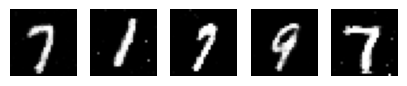

In [16]:
def show_generated_imgs(generator, latent_dim, num_images=5):
    z = torch.randn(num_images, latent_dim).to(device)
    gen_imgs = generator(z)
    gen_imgs = gen_imgs.view(gen_imgs.size(0), 1, 28, 28)
    gen_imgs = gen_imgs.detach().cpu().numpy()

    fig, axes = plt.subplots(1, num_images, figsize=(num_images, 1))
    for i in range(num_images):
        axes[i].imshow(np.transpose(gen_imgs[i], (1, 2, 0)).squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.show()

show_generated_imgs(generator, latent_dim)